In [1]:
from dotenv import load_dotenv
import os
from huggingface_hub import login

load_dotenv()



True

In [2]:
HUGGING_FACE_TOKEN = os.getenv("HUGGING_FACE_TOKEN")

# Authenticate
login(token=HUGGING_FACE_TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/teodorrk/.cache/huggingface/token
Login successful


In [3]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from tqdm.auto import tqdm


source_model_id = "Basemodel_369M/pytorch_model_1.bin"
peft_model_id = "Convmodel_369M/adapter_model_1.bin"

In [7]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, PeftModel

# Paths to your model and adapter files
base_model_path = "./Basemodel_369M"
adapter_model_path = "./Convmodel_369M/adapter_model.bin"
adapter_config_path = "./Convmodel_369M/adapter_config.json"

# Load the base model and tokenizer from local files
model = AutoModelForCausalLM.from_pretrained(base_model_path, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(base_model_path, local_files_only=True)

# Load the adapter configuration directly from the local JSON file
with open(adapter_config_path, 'r') as f:
    adapter_config_dict = json.load(f)

# Instantiate the LoraConfig object
lora_config = LoraConfig(**adapter_config_dict)

# Load the adapter model using the configuration
model = PeftModel(model, lora_config)

# Manually load the adapter weights
adapter_weights = torch.load(adapter_model_path, map_location="cpu")
model.load_state_dict(adapter_weights, strict=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PeftModel(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(64000, 1024)
        (wpe): Embedding(2048, 1024)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-23): 24 x GPT2Block(
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              

In [ ]:
## Prepare input
#input_text = "Once upon a time"
#inputs = tokenizer(input_text, return_tensors="pt").to(device)
#
## Generate text with adjusted parameters
#outputs = model.generate(
#    **inputs,
#    max_length=200,  # Adjust maximum length of generated text
#    num_return_sequences=1,  # Number of sequences to return
#    #temperature=0.7,  # Sampling temperature
#    #top_p=0.2,  # Top-p (nucleus) sampling
#    #top_k=50,  # Top-k sampling
#    do_sample=True,  # Whether to use sampling
#    pad_token_id=tokenizer.eos_token_id  # Ensure pad_token_id is set
#)
#
#generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
#
#print(generated_text)

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def execute_plot_code(plot_code: str):
    try:
        exec(plot_code)
    except Exception as e:
        print(f"Error executing plot code: {e}")

def generate_plot(user_input: str):
    # Prepare the prompt for the model with an example
    prompt = f"""Generate a Python code snippet to {user_input} using matplotlib for plotting.
Example:
<code>
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Sine Wave')
plt.grid(True)
plt.show()
</code>
Now generate the code:
<code>
"""

    # Encode the input and generate code
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    attention_mask = inputs.attention_mask.to(device)
    outputs = model.generate(inputs.input_ids, 
                             attention_mask=attention_mask, 
                             max_length=200, 
                             num_return_sequences=1, 
                             temperature=0.7, 
                             do_sample=True,
                             top_p=0.9,
                             pad_token_id=tokenizer.eos_token_id
                             )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract the code between <code> and </code>
    start_tag = "<code>"
    end_tag = "</code>"
    start_index = generated_text.find(start_tag) + len(start_tag)
    end_index = generated_text.find(end_tag)
    plot_code = generated_text[start_index:end_index].strip()
    
    # Print the generated code
    print("Generated Code:\n", plot_code)
    
    # Execute the generated code
    execute_plot_code(plot_code)

    # Show the plot
    plt.show()



In [28]:
def generate_text_response(user_input: str):
    # Prepare the prompt for the model with examples
    prompt = f"""Answer the following question:
Q: What is the capital of France?
A: The capital of France is Paris.

Q: What is the largest planet in our solar system?
A: The largest planet in our solar system is Jupiter.

Q: Explain the significance of the sine wave in signal processing.
A: The sine wave is fundamental in signal processing because it represents a pure frequency. It's used in Fourier analysis to decompose complex signals into simpler components.

Q: {user_input}
A:"""

    # Encode the input and generate text
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    attention_mask = inputs.attention_mask.to(device)
    outputs = model.generate(inputs.input_ids, 
                             attention_mask=attention_mask, 
                             max_length=200, 
                             num_return_sequences=1, 
                             temperature=0.7, 
                             do_sample=True,
                             pad_token_id=tokenizer.eos_token_id
                             )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Print the generated text response
    print("Generated Text:\n", generated_text)
    return generated_text


In [29]:
def handle_user_input(user_input: str):
    if "plot" in user_input.lower():
        generate_plot(user_input)
    else:
        response = generate_text_response(user_input)
        print(response)


Generated Code:
 import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('Sine Wave')
plt.grid(True)
plt.show()


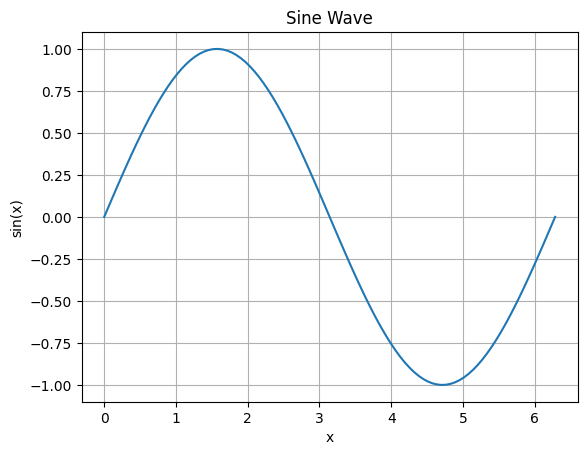

Generated Text:
 Answer the following question:
Q: What is the capital of France?
A: The capital of France is Paris.

Q: What is the largest planet in our solar system?
A: The largest planet in our solar system is Jupiter.

Q: Explain the significance of the sine wave in signal processing.
A: The sine wave is fundamental in signal processing because it represents a pure frequency. It's used in Fourier analysis to decompose complex signals into simpler components.

Q: Explain the significance of the sine wave in signal processing
A: The sin wave is fundamental in signal processing because it represents a pure frequency. It's used in Fourier analysis to decompose complex signals into simpler components. Üblicherweise wird ein Gleichgewichtskern in der Regel im Bereich der Zeiträume von 10 bis 25 Jahren in der Regel der Gleichgewichtskern verwendet. Voraussetzung dafür ist allerdings ein gleichmäß
Answer the following question:
Q: What is the capital of France?
A: The capital of France is

In [30]:
# Example user inputs
plot_input = "plot a sine wave with x ranging from 0 to 2*pi"
text_input = "Explain the significance of the sine wave in signal processing"

handle_user_input(plot_input)
handle_user_input(text_input)